In [1]:
import os

data_dir = './datasets/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


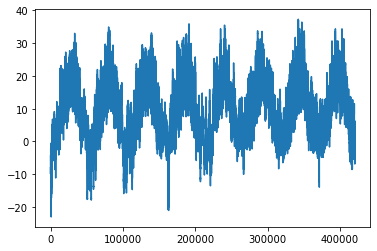

In [2]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
from matplotlib import pyplot as plt

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

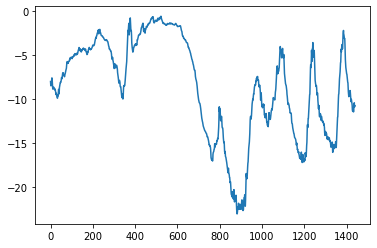

In [3]:
plt.plot(range(1440), temp[:1440])

In [3]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
        
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
            
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows), 
                            lookback // step, 
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
            
        yield(samples, targets)
        
lookback = 1440
step = 6
delay = 144
batch_size = 128
train_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=0,
                     max_index=200000,
                     shuffle=True,
                     step=step,
                     batch_size=batch_size)
val_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=200001,
                     max_index=300000,
                     step=step,
                     batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size

test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [5]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


In [6]:
celcius_mae = 0.29 * std[1]
print(celcius_mae)

2.5672247338393395


Epoch 1/20
500/500 [==============================] - 21s 42ms/step - loss: 1.4325 - val_loss: 0.6367
Epoch 2/20
500/500 [==============================] - 20s 39ms/step - loss: 0.4570 - val_loss: 0.3323
Epoch 3/20
500/500 [==============================] - 20s 39ms/step - loss: 0.2970 - val_loss: 0.2965
Epoch 4/20
500/500 [==============================] - 19s 39ms/step - loss: 0.2683 - val_loss: 0.3267
Epoch 5/20
500/500 [==============================] - 20s 40ms/step - loss: 0.2545 - val_loss: 0.3235
Epoch 6/20
500/500 [==============================] - 19s 38ms/step - loss: 0.2481 - val_loss: 0.3234
Epoch 7/20
500/500 [==============================] - 20s 40ms/step - loss: 0.2399 - val_loss: 0.3088
Epoch 8/20
500/500 [==============================] - 19s 39ms/step - loss: 0.2354 - val_loss: 0.3153
Epoch 9/20
500/500 [==============================] - 19s 39ms/step - loss: 0.2310 - val_loss: 0.3387
Epoch 10/20
500/500 [==============================] - 20s 40ms/step - loss: 0.227

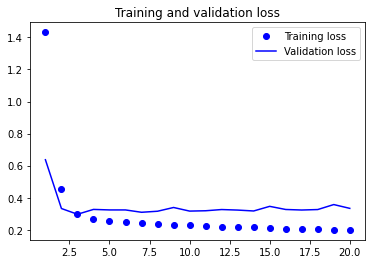

In [8]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Epoch 1/20
500/500 [==============================] - 137s 274ms/step - loss: 0.2977 - val_loss: 0.2726
Epoch 2/20
500/500 [==============================] - 130s 260ms/step - loss: 0.2820 - val_loss: 0.2640
Epoch 3/20
500/500 [==============================] - 108s 216ms/step - loss: 0.2766 - val_loss: 0.2654
Epoch 4/20
500/500 [==============================] - 100s 199ms/step - loss: 0.2730 - val_loss: 0.2668
Epoch 5/20
500/500 [==============================] - 108s 217ms/step - loss: 0.2709 - val_loss: 0.2641
Epoch 6/20
500/500 [==============================] - 111s 222ms/step - loss: 0.2655 - val_loss: 0.2637
Epoch 7/20
500/500 [==============================] - 104s 209ms/step - loss: 0.2597 - val_loss: 0.2627
Epoch 8/20
500/500 [==============================] - 116s 233ms/step - loss: 0.2572 - val_loss: 0.2688
Epoch 9/20
500/500 [==============================] - 103s 207ms/step - loss: 0.2527 - val_loss: 0.2672
Epoch 10/20
500/500 [==============================] - 104s 208m

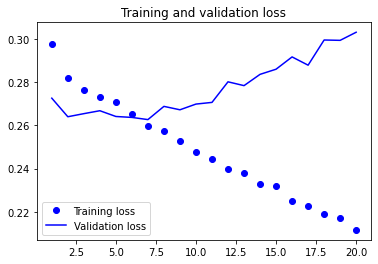

In [9]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None,  float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/40
500/500 [==============================] - 231s 461ms/step - loss: 0.3196 - val_loss: 0.2812
Epoch 2/40
500/500 [==============================] - 235s 470ms/step - loss: 0.3009 - val_loss: 0.2836
Epoch 3/40
500/500 [==============================] - 235s 471ms/step - loss: 0.2926 - val_loss: 0.2700
Epoch 4/40
500/500 [==============================] - 236s 472ms/step - loss: 0.2860 - val_loss: 0.2627
Epoch 5/40
500/500 [==============================] - 234s 467ms/step - loss: 0.2798 - val_loss: 0.2692
Epoch 6/40
500/500 [==============================] - 233s 465ms/step - loss: 0.2760 - val_loss: 0.2689
Epoch 7/40
500/500 [==============================] - 233s 466ms/step - loss: 0.2695 - val_loss: 0.2725
Epoch 8/40
500/500 [==============================] - 232s 465ms/step - loss: 0.2643 - val_loss: 0.2693
Epoch 9/40
500/500 [==============================] - 236s 472ms/step - loss: 0.2617 - val_l

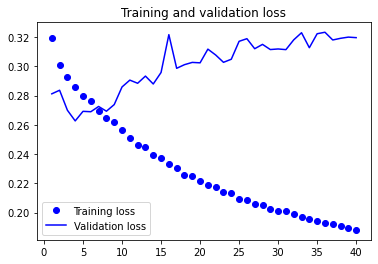

In [5]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                    dropout=0.1,
                    recurrent_dropout=0.5,
                    return_sequences=True,
                    input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                    dropout=0.1,
                    recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=40,
                             validation_data=val_gen,
                             validation_steps=val_steps)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [4]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                    dropout=0.1,
                    recurrent_dropout=0.5,
                    return_sequences=True,
                    input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                    dropout=0.1,
                    recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=40,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/40
500/500 [==============================] - 351s 703ms/step - loss: 0.3183 - val_loss: 0.2967
Epoch 2/40
500/500 [==============================] - 337s 673ms/step - loss: 0.3031 - val_loss: 0.2750
Epoch 3/40
500/500 [==============================] - 360s 720ms/step - loss: 0.2943 - val_loss: 0.2734
Epoch 4/40
500/500 [==============================] - 365s 731ms/step - loss: 0.2882 - val_loss: 0.2681
Epoch 5/40
500/500 [==============================] - 376s 752ms/step - loss: 0.2817 - val_loss: 0.2660
Epoch 6/40
500/500 [==============================] - 363s 726ms/step - loss: 0.2780 - val_loss: 0.2697
Epoch 7/40
500/500 [==============================] - 359s 719ms/step - loss: 0.2724 - val_loss: 0.2756
Epoch 8/40
500/500 [==============================] - 375s 750ms/step - loss: 0.2672 - val_loss: 0.2746
Epoch 9/40
500/500 [==============================] - 386s 771ms/step - loss: 0.2625 - val_l

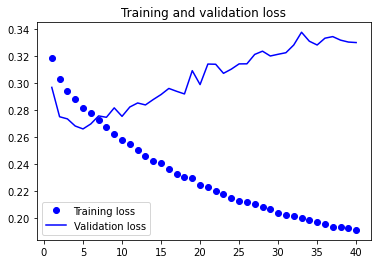

In [5]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()